In [214]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve
from sklearn.pipeline import Pipeline

In [153]:
fake = pd.read_csv('C:/Users/SIMPLON/Desktop/FAKE_NEWS/Fake.csv')
true = pd.read_csv('C:/Users/SIMPLON/Desktop/FAKE_NEWS/True.csv')

In [154]:
fake.head()
fake.shape

(23481, 4)

In [155]:
#true.head()
#true.shape

In [156]:
#true['text'][0]

In [160]:
#fake['text'][0]

In [161]:
fake['text'].isnull().sum()

0

In [162]:
fake['text'].isna().sum()

0

In [163]:
true['text'].isnull().sum()

0

In [164]:
true['text'].isna().sum()

0

# Fake

In [165]:
len(fake)

23481

In [166]:
# checking for rows with empty text in fake news 
empty_fake_index = [index for index,text in enumerate(fake.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake.iloc[empty_fake_index].tail()

No of empty rows: 630


title text    subject  \
21816  BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...       left-news   
21826  FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...       left-news   
21827  (VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...       left-news   
21857  (VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...       left-news   
21873  (VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...       left-news   

               date  
21816  Apr 27, 2015  
21826  Apr 25, 2015  
21827  Apr 25, 2015  
21857  Apr 14, 2015  
21873  Apr 12, 2015

In [167]:
#dropping this record
fake = fake.drop(empty_fake_index, axis=0)

-Les titres en capital_cases

-Pas des ressources pour les données(Text)
-630 text vide

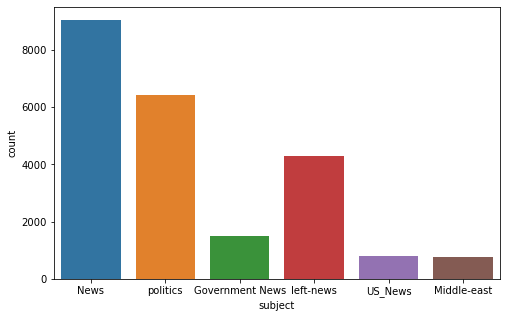

In [168]:
plt.figure(figsize=(8,5))
sns.countplot("subject", data=fake)
plt.show()

the differnt subjects of fake news:

    -NEWS
    
    -polictcs
    
    -Govermment News
    
    -left_news
    
    -US_News
    
    -Middle_east

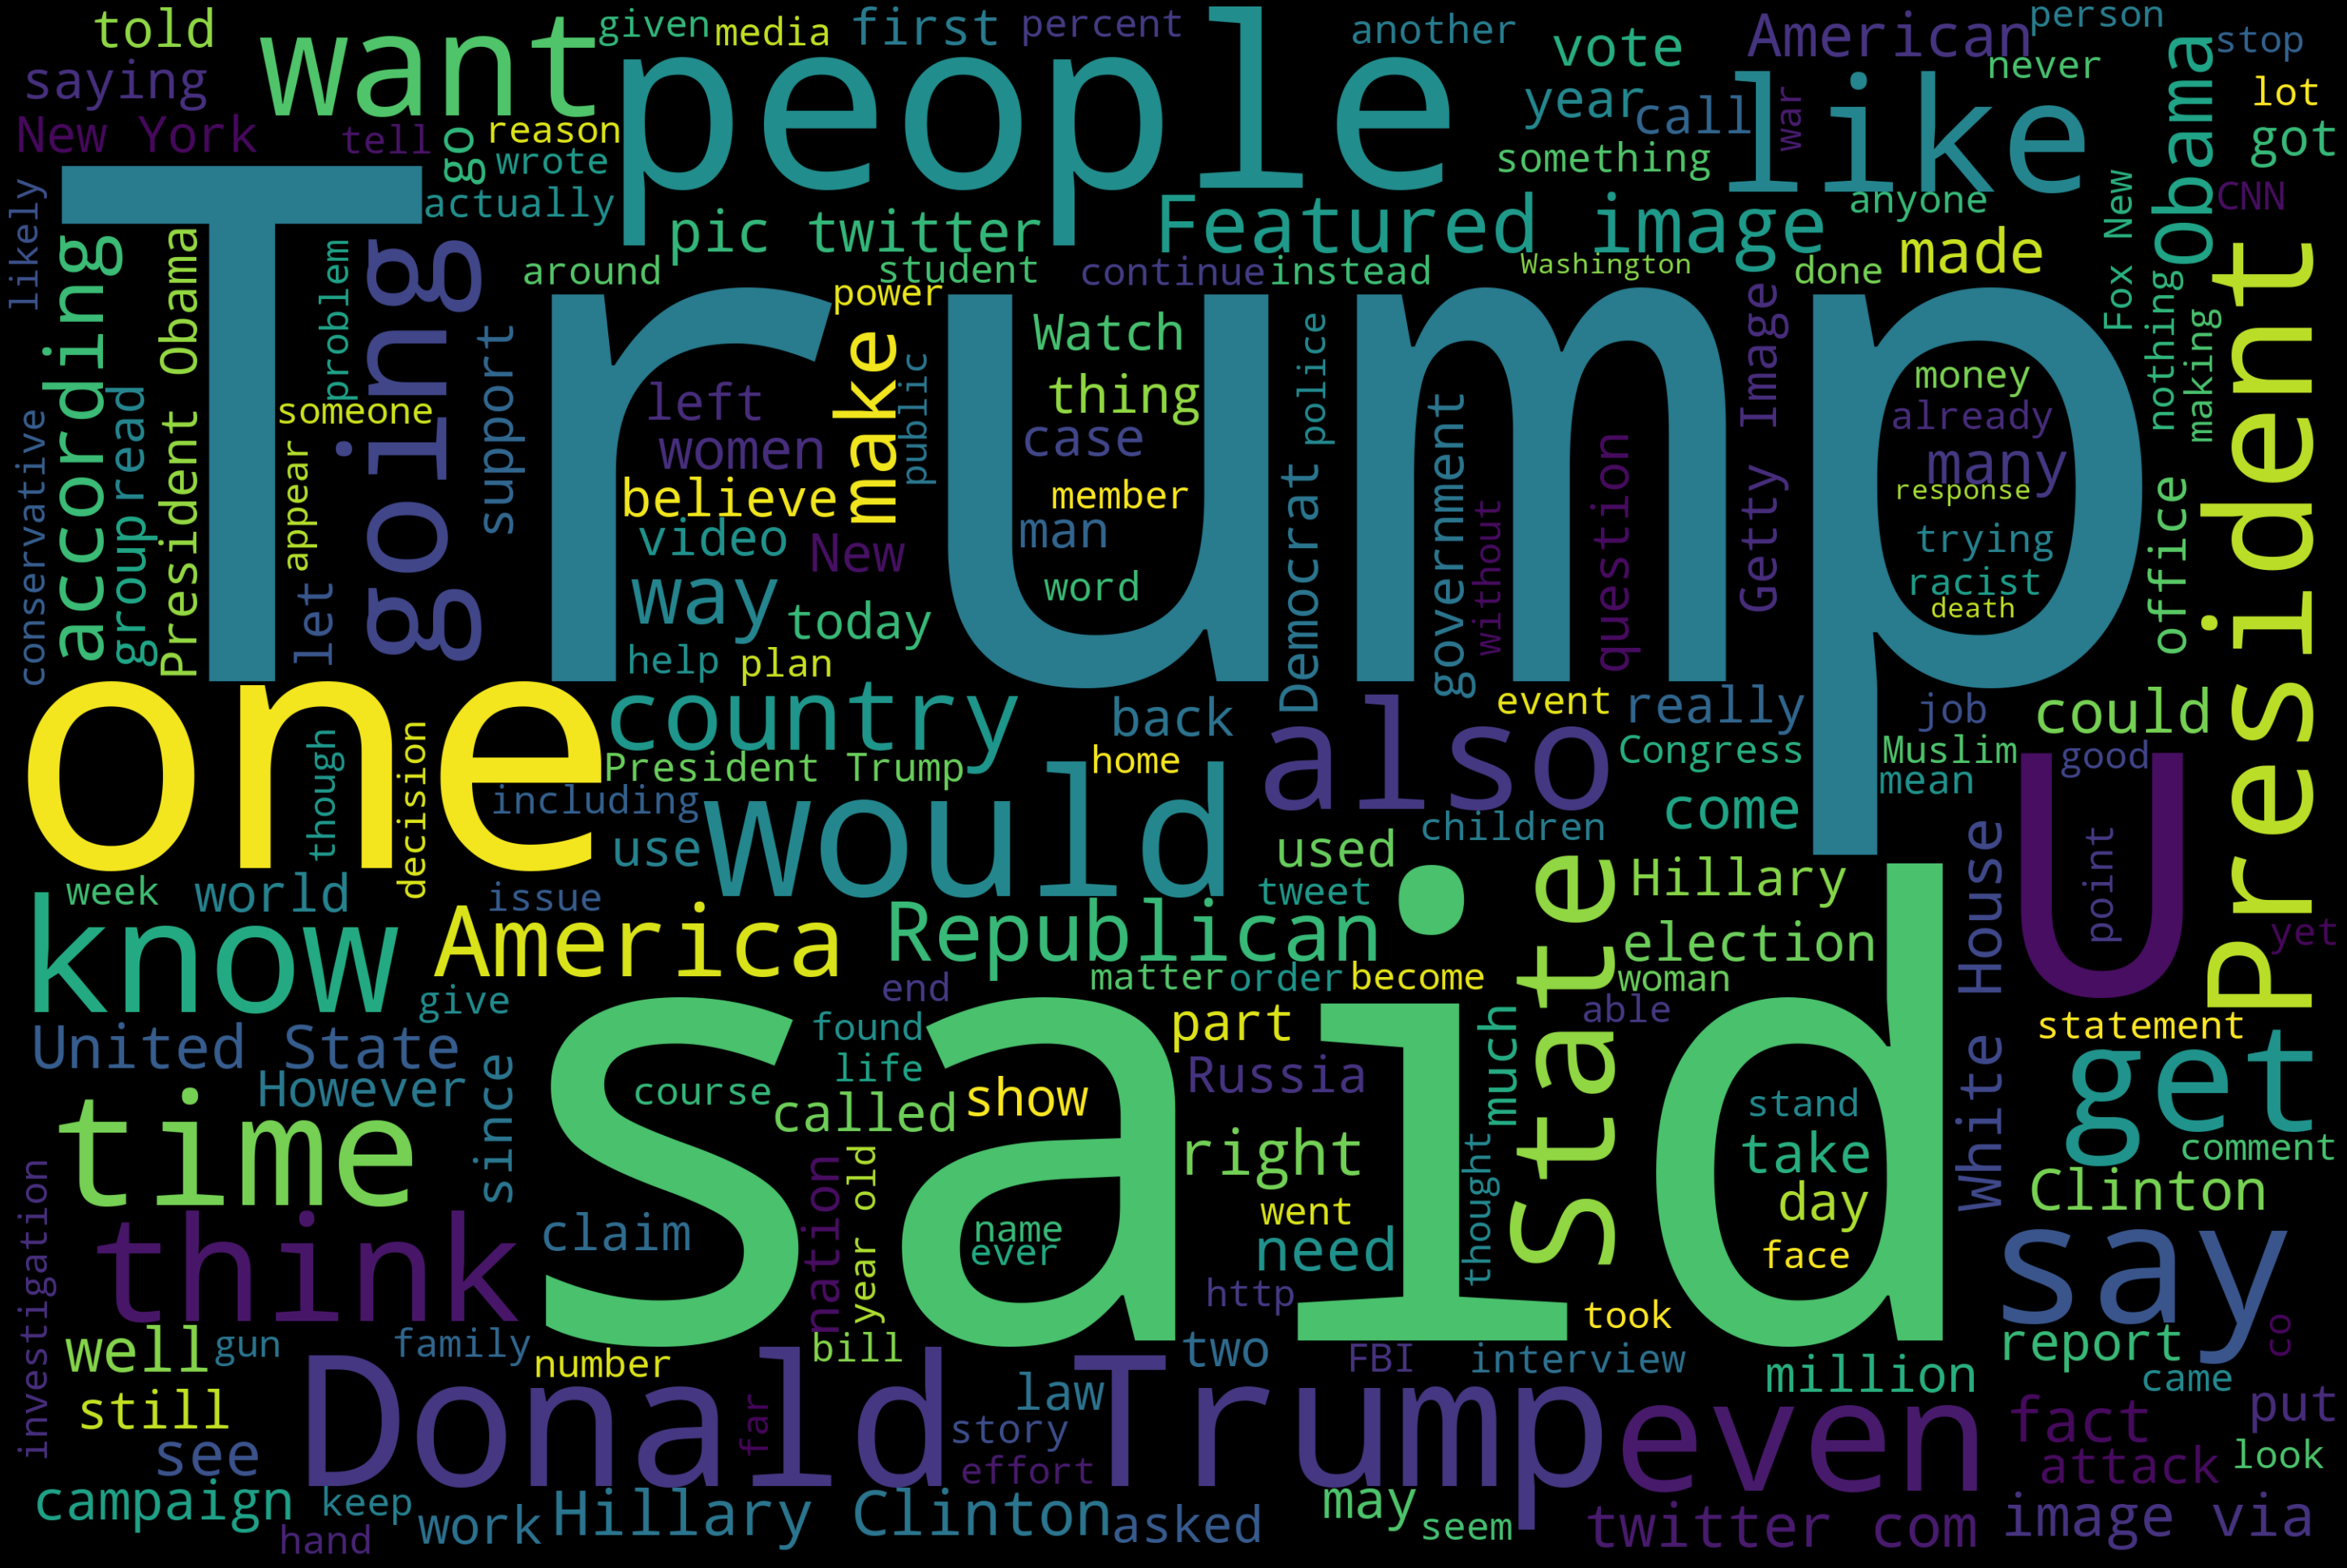

In [78]:
#Word Cloud
text = ''
for news in fake.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

# True

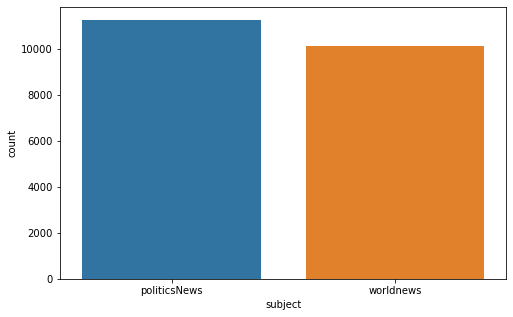

In [169]:
plt.figure(figsize=(8,5))
sns.countplot("subject", data=true)
plt.show()

.The different subject of True News:

    -Politcs News
    
    -Worldnews
    
. Presque toutes les données ont de ressources de données(text)

. La taille MAX de text est les tweets twitter avec 259 caracteres max 

.Faire le netoyage en enlevant les sources des données  et "-"

In [170]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(true.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [171]:
#Thus we have list of indices where publisher is not mentioned
#lets check
true.iloc[unknown_publishers].text
#true, they do not have text like "WASHINGTON (Reuters)"

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [172]:
true.iloc[8970]
#yep empty
#will remove this soon

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [173]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(true.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [174]:
#Replace existing text column with new text
#add seperate column for publication info
true["publisher"] = publisher
true["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [175]:
#checking for rows with empty text like row:8970
[index for index,text in enumerate(true.text.values) if str(text).strip() == '']
#seems only one :)

[8970]

In [176]:
#dropping this record
true = true.drop(8970, axis=0)

In [177]:
for name,count in true.publisher.value_counts().iteritems():
    print(f"Name: {name}\nCount: {count}\n")

Name: WASHINGTON (Reuters)
Count: 6389

Name: (Reuters)
Count: 1483

Name: LONDON (Reuters)
Count: 705

Name: NEW YORK (Reuters)
Count: 695

Name: MOSCOW (Reuters)
Count: 623

Name: BERLIN (Reuters)
Count: 499

Name: BEIJING (Reuters)
Count: 433

Name: BEIRUT (Reuters)
Count: 346

Name: BRUSSELS (Reuters)
Count: 346

Name: PARIS (Reuters)
Count: 301

Name: ANKARA (Reuters)
Count: 246

Name: MEXICO CITY (Reuters)
Count: 226

Name: TOKYO (Reuters)
Count: 207

Name: SEOUL (Reuters)
Count: 203

Name: GENEVA (Reuters)
Count: 197

Name: UNITED NATIONS (Reuters)
Count: 184

Name: MADRID (Reuters)
Count: 182

Name: DUBAI (Reuters)
Count: 174

Name: CAIRO (Reuters)
Count: 160

Name: MANILA (Reuters)
Count: 151

Name: ISTANBUL (Reuters)
Count: 140

Name: HARARE (Reuters)
Count: 140

Name: BAGHDAD (Reuters)
Count: 136

Name: CHICAGO (Reuters)
Count: 136

Name: NAIROBI (Reuters)
Count: 125

Name: SYDNEY (Reuters)
Count: 114

Name: JERUSALEM (Reuters)
Count: 107

Name: JOHANNESBURG (Reuters)
Count:

Name: ERBIL/LONDON, Iraq (Reuters)
Count: 1

Name: SANT’ANNA DI STAZZEMA, Italy (Reuters)
Count: 1

Name: MEXICO CITY/WASHINGTON (Reuters)
Count: 1

Name: MYEBON, Myanmar (Reuters)
Count: 1

Name: CHICAGO/SAN FRANCISCO (Reuters)
Count: 1

Name: UMUAHIA, Nigeria (Reuters)
Count: 1

Name: October 31 (Reuters)
Count: 1

Name: WASHINGTON/PHOENIX, Ariz. (Reuters)
Count: 1

Name: QUETTA, Pakistan/JAKARTA (Reuters)
Count: 1

Name:  (This October 11 story has been refiled to add Puigdemont s first name, title in paragraph three.) By Blanca Rodr guez and Sonya Dowsett MADRID/BARCELONA (Reuters)
Count: 1

Name: BANGUI (Reuters)
Count: 1

Name:  MOSCOW/WASHINGTON (Reuters)
Count: 1

Name: WASHINGTON/LONG BEACH, California (Reuters)
Count: 1

Name:  SACRAMENTO, Calif. (Reuters)
Count: 1

Name: WASHINGTON/WINSTON-SALEM, N.C. (Reuters)
Count: 1

Name:  (This October 18 story has been refiled to fix dateline, amend headline and first paragraph) ANGOOR ADDA, Pakistan (Reuters)
Count: 1

Name: WASHINGT

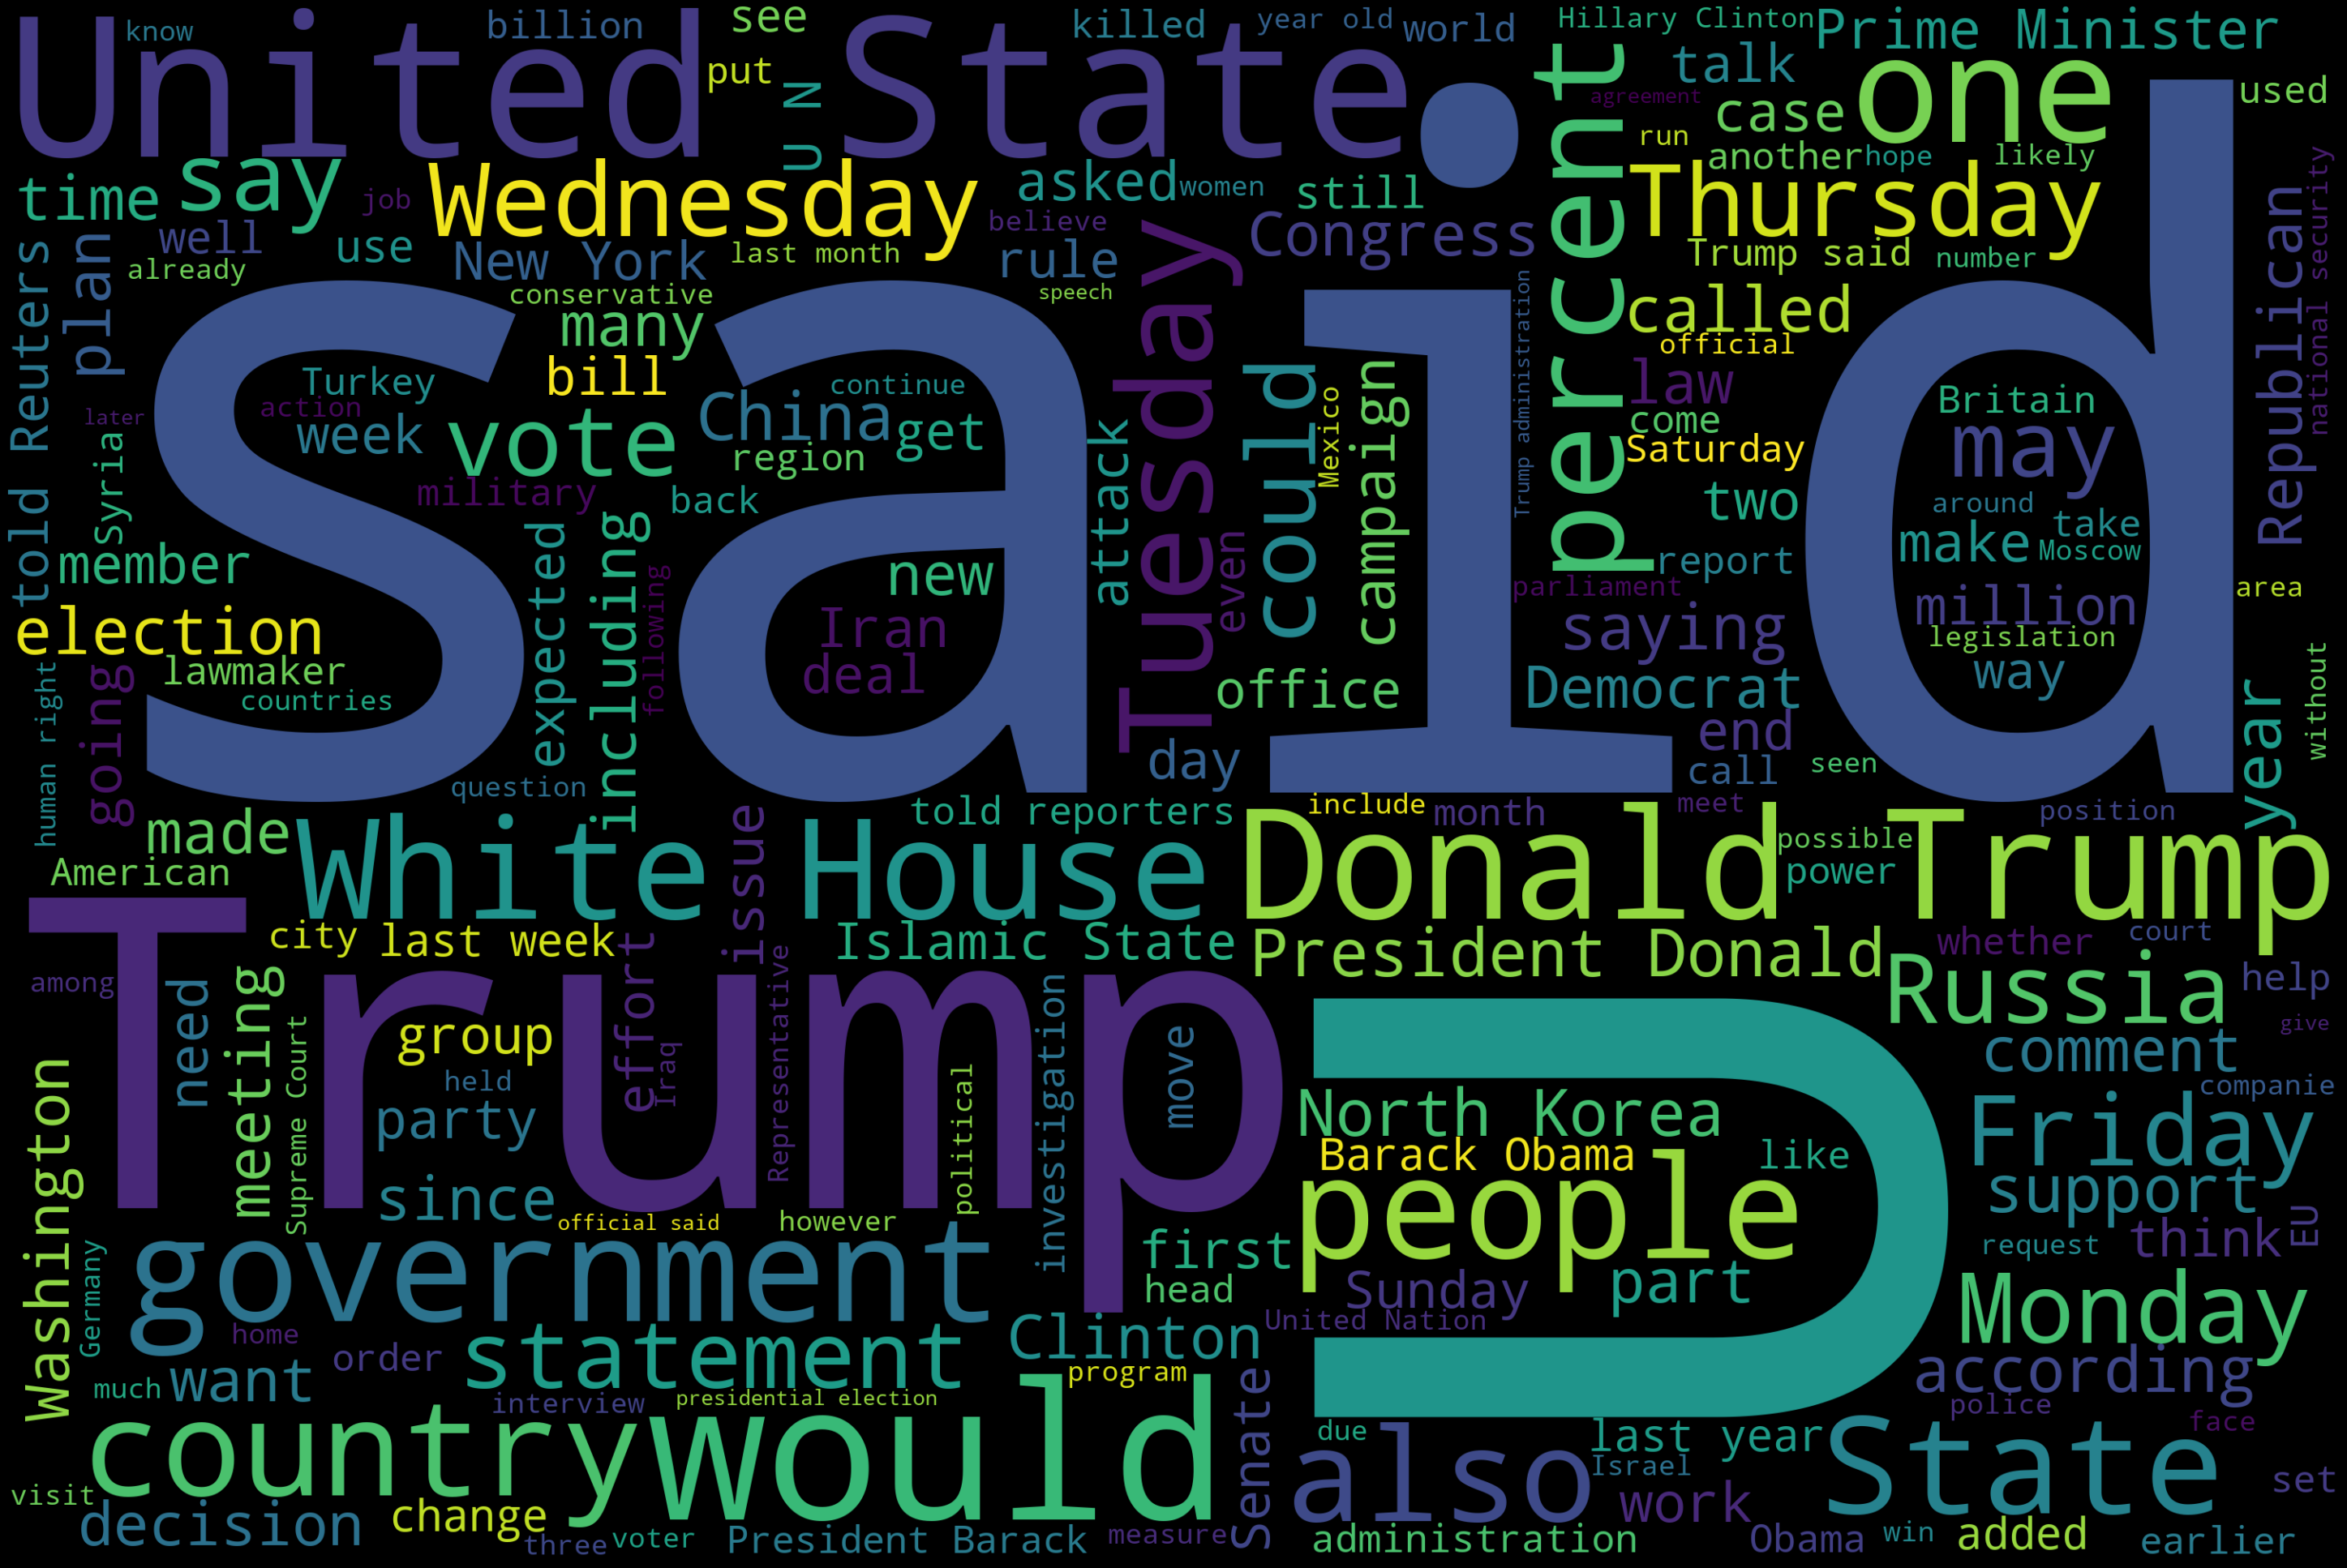

In [116]:
#WordCloud For Real News
text = ''
for news in true.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

# Concat

In [181]:
fake['is_fake'] = 1
true['is_fake'] = 0

In [182]:
#Combining both into new dataframe
concat = true.append(fake, ignore_index=True)
concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44267 entries, 0 to 44266
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44267 non-null  object
 1   text       44267 non-null  object
 2   subject    44267 non-null  object
 3   date       44267 non-null  object
 4   publisher  21416 non-null  object
 5   is_fake    44267 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 2.0+ MB


In [183]:
from hashlib import sha256
from tqdm import tqdm
list_ = [ ]
for text in tqdm(concat['text']):
    hash_ = sha256(text.encode('utf-8')).hexdigest()
    list_.append(hash_)
concat['hash'] = list_
t = concat.groupby(['hash']).size().reset_index(name='count')
duplicate = t[t['count']>1]
print('there are ',duplicate.shape[0]/len(concat)*100, 'duplicate texts')

100%|█████████████████████████████████████████████████████████████████████████| 44267/44267 [00:00<00:00, 72966.82it/s]

there are  11.609099329071318 duplicate texts


In [186]:
import re
def count_twitters_user(df):
    twitter_username_re = re.compile(r'@([A-Za-z0-9_]+)')
    count = 0
    list_ = []
    for text in df['text']:
        count += len(re.findall(twitter_username_re, text))
    return count


In [187]:
import plotly.express as px


twitter_users_fake_count = count_twitters_user(fake)
twitter_users_true_count = count_twitters_user(true)
fig = go.Figure()
fig.add_trace(go.Bar(x=['Fake', 'True'],
    y=[twitter_users_fake_count, twitter_users_true_count],
    name='Twitter user name Pattern',
    marker_color='indianred')
)
fig.update_layout({
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        'title': 'unique hashtags mentions in twitters',
})
#fig = px.bar(y=[twitter_users_fake_count, twitter_users_true_count], x=['Fake', 'True'], title='Twitter user name Pattern')
fig.show()


In [188]:
# En ce qui concerne le true news et le fake news ont une présence beaucoup plus grande de @ twitter

<AxesSubplot:xlabel='subject', ylabel='count'>

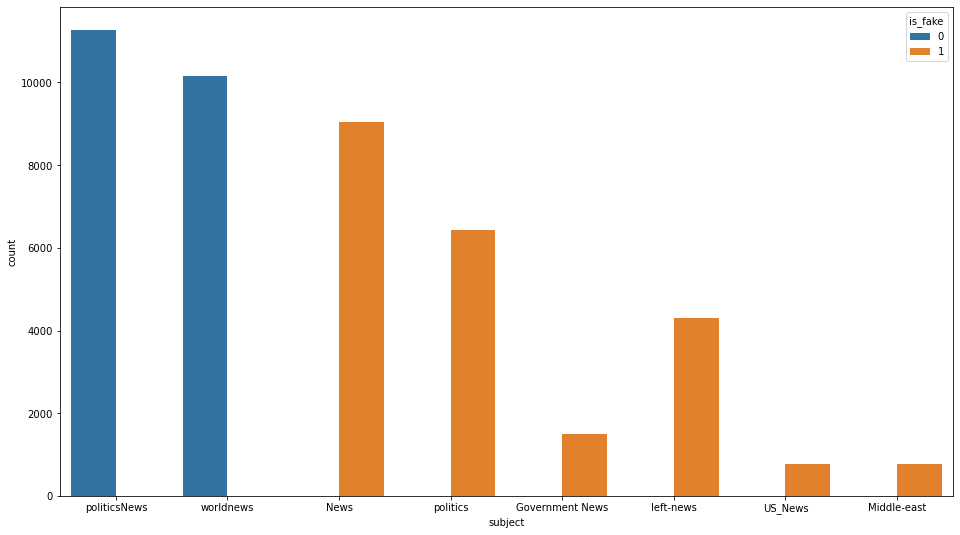

In [189]:
plt.figure(figsize=(16,9))
sns.countplot(x='subject',hue='is_fake',data=concat)

# duplicate

In [192]:
true.text.duplicated().sum()

226

In [193]:
true.duplicated().sum()

206

In [194]:
fake.text.duplicated().sum()

5398

In [195]:
#true.text.drop_duplicates()

In [196]:
#fake.text.drop_duplicates()

# Combining Title and Text

In [197]:
#Combining Title and Text
true["text"] = true["title"] + " " + true["text"]
fake["text"] = fake["title"] + " " + fake["text"]

In [198]:
# Subject is diffrent for real and fake thus dropping it
# Aldo dropping Date, title and Publication Info of real
true = true.drop(["subject", "date","title",  "publisher"], axis=1)
fake = fake.drop(["subject", "date", "title"], axis=1)

In [199]:
#Combining both into new dataframe
data = true.append(fake, ignore_index=True)


In [200]:
data.columns

Index(['text', 'is_fake'], dtype='object')

In [201]:
data.text.duplicated().sum()

5610

In [202]:
data.duplicated().sum()

5610

In [203]:
data=data.drop_duplicates()

<AxesSubplot:xlabel='is_fake', ylabel='count'>

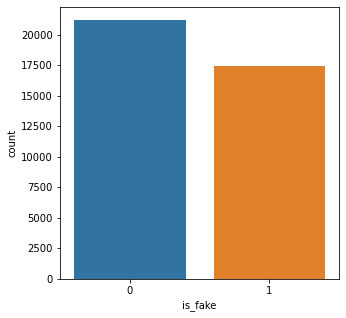

In [204]:
plt.figure(figsize=(5,5))
sns.countplot('is_fake',data=data)

In [207]:
data['is_fake'].value_counts()/len(data)*100

0    54.828362
1    45.171638
Name: is_fake, dtype: float64

In [208]:
### Create function to remove punctuation, tokenize, remove stopwords, and stem
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwords_En = nltk.corpus.stopwords.words('english')
import nltk
ps = nltk.PorterStemmer()
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
     #tokens = re.split('\W+', text)
    tokens = word_tokenize(text)
    text = " ".join([ps.stem(word) for word in tokens if word not in stopwords_En])
    return text
data['cleaned_text'] = data['text'].apply(lambda x: clean_text(x))
data.head()

text  is_fake  \
0  As U.S. budget fight looms, Republicans flip t...        0   
1  U.S. military to accept transgender recruits o...        0   
2  Senior U.S. Republican senator: 'Let Mr. Muell...        0   
3  FBI Russia probe helped by Australian diplomat...        0   
4  Trump wants Postal Service to charge 'much mor...        0   

                                        cleaned_text  
0  us budget fight loom republican flip fiscal sc...  
1  us militari accept transgend recruit monday pe...  
2  senior us republican senat let mr mueller job ...  
3  fbi russia probe help australian diplomat tipo...  
4  trump want postal servic charg much amazon shi...

In [209]:
# save
data.to_csv('text.csv')

# After drop duplicate

In [210]:
df=data.copy()
#df.head()
y=df.is_fake
X=df.cleaned_text

In [211]:
# Preparing training and testing data using train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state= 2022,stratify=y)

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state= 2022,stratify=y)
y=df.is_fake
X=df.text

In [220]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
logreg_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('logreg',LogisticRegression(solver='liblinear'))
])
logreg_pipe.fit(X_train,y_train)


Pipeline(steps=[('tvec', TfidfVectorizer()),
                ('logreg', LogisticRegression(solver='liblinear'))])

In [217]:
logreg_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tvec', 'logreg', 'tvec__analyzer', 'tvec__binary', 'tvec__decode_error', 'tvec__dtype', 'tvec__encoding', 'tvec__input', 'tvec__lowercase', 'tvec__max_df', 'tvec__max_features', 'tvec__min_df', 'tvec__ngram_range', 'tvec__norm', 'tvec__preprocessor', 'tvec__smooth_idf', 'tvec__stop_words', 'tvec__strip_accents', 'tvec__sublinear_tf', 'tvec__token_pattern', 'tvec__tokenizer', 'tvec__use_idf', 'tvec__vocabulary', 'logreg__C', 'logreg__class_weight', 'logreg__dual', 'logreg__fit_intercept', 'logreg__intercept_scaling', 'logreg__l1_ratio', 'logreg__max_iter', 'logreg__multi_class', 'logreg__n_jobs', 'logreg__penalty', 'logreg__random_state', 'logreg__solver', 'logreg__tol', 'logreg__verbose', 'logreg__warm_start'])

In [222]:
#params de grid
grid={ 'tvec__max_df': (0.5, 0.75, 1.0),
       'tvec__max_features': (None, 5000, 10000),
        'tvec__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
         'tvec__use_idf': (True, False),
    "logreg__C":np.logspace(-3,3,7),
      "logreg__penalty":["l1","l2", 'elasticnet']}# l1 lasso l2 ridge


In [223]:
#grid search 
logreg_cv=GridSearchCV(logreg_pipe,grid,cv=5, verbose = 1, n_jobs = -1)

In [ ]:
logreg_cv.fit(X_train,y_train)


Fitting 5 folds for each of 756 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 69.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 134.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 211.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 310.4min


In [ ]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

In [ ]:
model_logreg=logreg_cv.best_estimator_
model_logreg

In [ ]:
y_pred_log=model_logreg.predict(X_test)


In [ ]:
print('Accuracy: ', accuracy_score(y_test, y_pred_log))
print('Precision: ', precision_score(y_test,y_pred_log))
print('Recall: ', recall_score(y_test, y_pred_log))
print('f1-score: ', f1_score(y_test,y_pred_log))

In [ ]:
# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
print(classification_report(y_test,y_pred_log))
print(confusion_matrix(y_test,y_pred_log))

In [ ]:
cfm=confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm,
                               display_labels=model_logreg.classes_)
disp.plot()